Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
NUM_KNAPSACKS = 3
NUM_ITEMS = 10
NUM_DIMENSIONS = 2

In [3]:
VALUES = np.random.randint(0, 100, size=NUM_ITEMS)
WEIGHTS = np.random.randint(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = np.random.randint(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [4]:
def fitness(solution):
    """Calculate the fitness of a given solution."""
    return np.sum(VALUES[solution >= 0])

def is_feasible(solution):
    """Check if a given solution is feasible."""
    # Check constraints for each knapsack
    for k in range(NUM_KNAPSACKS):
        if np.any(np.sum(WEIGHTS[solution == k], axis=0) > CONSTRAINTS[k]):
            return False
    return True

def get_solution():
    """Generate a random feasible solution."""
    # Start with a random assignment
    solution = np.random.choice(np.arange(NUM_KNAPSACKS), size=NUM_ITEMS)
    # Remove items until the solution is feasible
    while not is_feasible(solution):
        i = np.random.randint(0, NUM_ITEMS)
        solution[i] = -1
    return solution

In [5]:
class ExperimentResult:
    """Class to store and analyze the results of an experiment."""
    def __init__(self, name):
        self.name = name
        self.fitness_history = []
        self.best_solution = None
        self.best_fitness = -1
        self.restarts = []
    
    def add_fitness(self, fitness, solution):
        """"Add a new fitness value and update the best solution if necessary."""
        self.fitness_history.append(fitness)
        if fitness > self.best_fitness:
            self.best_fitness = fitness
            self.best_solution = solution.copy()
    
    def plot_fitness(self):
        """Plot the fitness history with restarts and optimal fitness."""
        _, ax = plt.subplots()
        # Plot cumulative max fitness
        ax.plot(self.fitness_history, label="Cumulative max fitness")
        # If there are restarts, plot vertical lines
        if len(self.restarts) > 0:
            for r in self.restarts:
                ax.axvline(r, color='red', linestyle='--', alpha=0.5, label="Restart" if r == self.restarts[0] else "")
        # Plot optimal fitness line, assuming optimal is sum of all VALUES
        ax.axhline(np.sum(VALUES), color='green', linestyle='--', alpha=0.5, label="Optimal")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Fitness")
        ax.set_title(self.name)
        ax.set_xlim(0, len(self.fitness_history))
        ax.set_ylim(0, np.sum(VALUES) * 1.1)
        ax.legend(loc='lower right')
        plt.show()
        return ax
    
    def join(self, other):
        """Join another ExperimentResult into this one."""
        # Store the restart point
        self.restarts.append(len(self.fitness_history))
        # Extend fitness history
        self.fitness_history.extend(other.fitness_history)
        # Update best solution if the other is better
        if other.best_fitness > self.best_fitness:
            self.best_fitness = other.best_fitness
            self.best_solution = other.best_solution.copy()
    
    def __str__(self):
        """String representation of the experiment results."""
        header = f"Experiment: {self.name}\n"
        best = f"Best Fitness: {self.best_fitness}\n"
        # Detailed best solution
        for k in range(NUM_KNAPSACKS):
            best += f" Knapsack {k}: items {np.where(self.best_solution == k)[0].tolist()}\n"
        best += f" Unassigned items: {np.where(self.best_solution == -1)[0].tolist()}\n"
        return header + best

In [6]:
def tweak(solution):
    """Generate a neighboring solution by tweaking the current solution."""
    # Choose a random item
    i = np.random.randint(0, NUM_ITEMS)
    feasible_choices = np.arange(-1, NUM_KNAPSACKS)
    # Choose a new backpack for the item OR unassign it
    new_value = np.random.choice(feasible_choices)
    while new_value == solution[i]:
        new_value = np.random.choice(feasible_choices)
    new_solution = solution.copy()
    new_solution[i] = new_value
    # If we unassigned an item, assign the backpack to a random unassigned item (if any)
    if new_value == -1:
        old_value = new_solution[i]
        unassigned_items = np.arange(NUM_ITEMS)[solution == -1]
        if len(unassigned_items) >= 1:
            j = np.random.choice(unassigned_items)
            new_solution[j] = old_value
    return new_solution

In [7]:
def hc_solver(solution, max_iter=10000):
    """Hill Climbing solver for the knapsack problem."""
    best_solution = solution.copy()
    best_fitness = fitness(solution) if is_feasible(solution) else 0
    results = ExperimentResult("Hill Climbing")
    results.add_fitness(best_fitness, best_solution)
    for _ in tqdm(range(max_iter)):
        new_solution = tweak(best_solution)
        if is_feasible(new_solution):
            new_fitness = fitness(new_solution)
            if new_fitness >= best_fitness:
                best_solution = new_solution
                best_fitness = new_fitness
        results.add_fitness(best_fitness, best_solution)
    return results

In [8]:
def hc_steepest_ascent_solver(solution, max_iter=1000):
    best_solution = solution.copy()
    best_fitness = fitness(solution) if is_feasible(solution) else 0
    results = ExperimentResult("Steepest Ascent Hill Climbing")
    results.add_fitness(best_fitness, best_solution)
    for _ in tqdm(range(max_iter)):
        neighbors = [tweak(best_solution) for _ in range(10)]
        feasible_neighbors = [s for s in neighbors if is_feasible(s)]
        if not feasible_neighbors:
            results.add_fitness(best_fitness, best_solution)
            continue
        new_solution = max(feasible_neighbors, key=fitness)
        new_fitness = fitness(new_solution)
        if new_fitness >= best_fitness:
            best_solution = new_solution
            best_fitness = new_fitness
        results.add_fitness(best_fitness, best_solution)
    return results

In [9]:
def sa_solver(solution, max_iter=10000, initial_temp=100, cooling_rate=0.99, restarted=False):
    current_solution = solution.copy()
    current_fitness = fitness(solution) if is_feasible(solution) else 0
    results = ExperimentResult("Simulated Annealing")
    results.add_fitness(current_fitness, current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness
    temp = initial_temp
    for _ in tqdm(range(max_iter)):
        new_solution = tweak(current_solution)
        if is_feasible(new_solution):
            new_fitness = fitness(new_solution)
            if new_fitness >= current_fitness:
                current_solution = new_solution
                current_fitness = new_fitness
                if new_fitness >= best_fitness:
                    best_solution = new_solution
                    best_fitness = new_fitness
                if restarted and new_fitness >= best_fitness:
                    temp = initial_temp
            else:
                acceptance_prob = np.exp((new_fitness - current_fitness) / temp)
                if np.random.rand() < acceptance_prob:
                    current_solution = new_solution
                    current_fitness = new_fitness
        temp *= cooling_rate
        results.add_fitness(best_fitness, best_solution)
    return results

## Test problem 1

In [10]:
# Problem 1:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 3
NUM_ITEMS = 20
NUM_DIMENSIONS = 2
VALUES = rng.integers(0, 100, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 100, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    0, 100 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [11]:
solution = np.ones(NUM_ITEMS, dtype=int) * -1
solution = get_solution()

100%|██████████| 500/500 [00:00<00:00, 8391.66it/s]


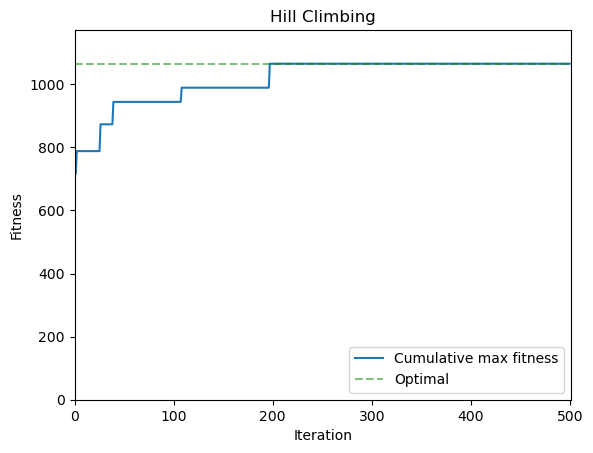

Experiment: Hill Climbing
Best Fitness: 1065
 Knapsack 0: items [0, 2, 4, 6, 7, 9, 10, 15, 16, 17, 18, 19]
 Knapsack 1: items [1, 3, 8, 12, 13]
 Knapsack 2: items [5, 11, 14]
 Unassigned items: []



In [12]:
results = hc_solver(solution, max_iter=500)
results.plot_fitness()
print(results)

100%|██████████| 50/50 [00:00<00:00, 907.93it/s]


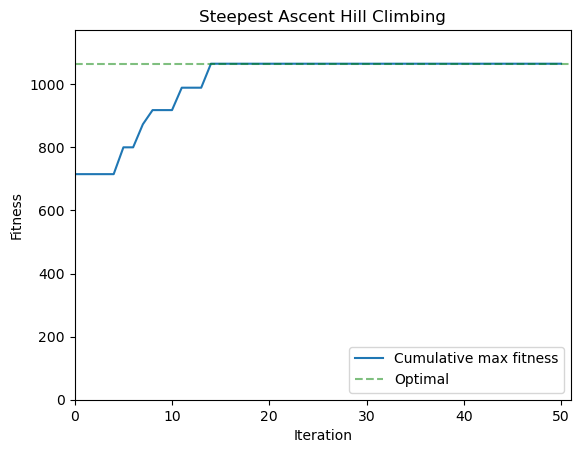

Experiment: Steepest Ascent Hill Climbing
Best Fitness: 1065
 Knapsack 0: items [0, 5, 6, 7, 8, 9, 14, 16, 18, 19]
 Knapsack 1: items [1, 10, 11, 12, 13, 17]
 Knapsack 2: items [2, 3, 4, 15]
 Unassigned items: []



In [13]:
results = hc_steepest_ascent_solver(solution, max_iter=50)
results.plot_fitness()
print(results)

100%|██████████| 500/500 [00:00<00:00, 6474.63it/s]


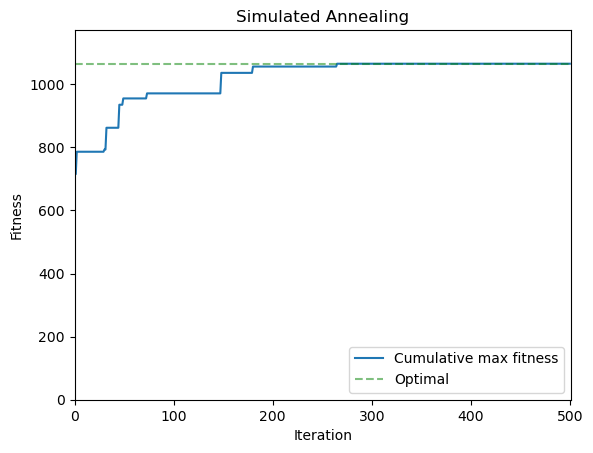

Experiment: Simulated Annealing
Best Fitness: 1065
 Knapsack 0: items [1, 2, 3, 7, 13, 14, 15, 16, 18]
 Knapsack 1: items [5, 6, 8, 10, 12, 19]
 Knapsack 2: items [0, 4, 9, 11, 17]
 Unassigned items: []



In [14]:
results = sa_solver(solution, max_iter=500)
results.plot_fitness()
print(results)

## Test problem 2

In [15]:
# Problem 2:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 10
NUM_ITEMS = 100
NUM_DIMENSIONS = 10
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 2, 1000 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [16]:
solution = np.ones(NUM_ITEMS, dtype=int) * -1
solution = get_solution()

100%|██████████| 50000/50000 [00:06<00:00, 7440.39it/s]


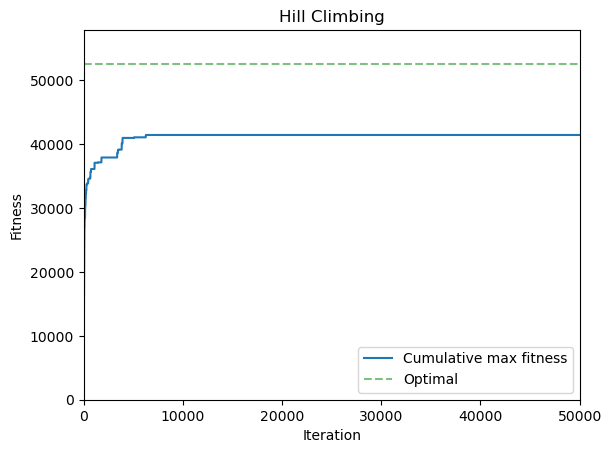

Experiment: Hill Climbing
Best Fitness: 41460
 Knapsack 0: items [30, 35, 46, 49, 61, 64]
 Knapsack 1: items [23, 36, 39, 42, 55, 75, 91]
 Knapsack 2: items [12, 38, 44, 45, 78, 80]
 Knapsack 3: items [7, 9, 19, 20, 33, 41, 62, 70, 72, 74]
 Knapsack 4: items [6, 15, 29, 31, 82, 86, 88, 93, 97, 99]
 Knapsack 5: items [8, 18, 24, 53, 63, 67, 68, 71]
 Knapsack 6: items [11, 22, 25, 28, 51, 52, 84, 92]
 Knapsack 7: items [43, 47, 59, 60, 79, 90]
 Knapsack 8: items [1, 4, 5, 37, 40, 87, 94, 96]
 Knapsack 9: items [13, 14, 17, 32, 34, 50, 65, 73, 77, 85]
 Unassigned items: [0, 2, 3, 10, 16, 21, 26, 27, 48, 54, 56, 57, 58, 66, 69, 76, 81, 83, 89, 95, 98]



In [17]:
results = hc_solver(solution, max_iter=50000)
results.plot_fitness()
print(results)

 70%|███████   | 70308/100000 [00:08<00:04, 7029.62it/s]/tmp/ipykernel_111746/39911299.py:22: RuntimeWarning: overflow encountered in divide
  acceptance_prob = np.exp((new_fitness - current_fitness) / temp)
100%|██████████| 100000/100000 [00:12<00:00, 7876.65it/s]


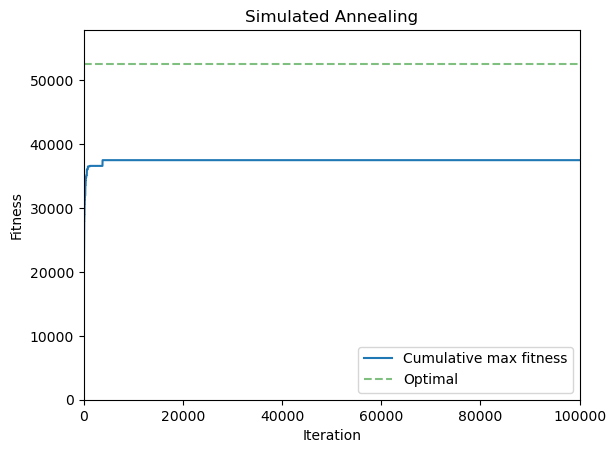

Experiment: Simulated Annealing
Best Fitness: 37517
 Knapsack 0: items [19, 22, 28, 32, 35, 47, 49]
 Knapsack 1: items [14, 36, 42, 52, 55, 77, 82, 90]
 Knapsack 2: items [24, 40, 43, 50, 70, 85]
 Knapsack 3: items [27, 37, 60, 74, 92, 98, 99]
 Knapsack 4: items [10, 13, 17, 23, 25, 26, 31, 73, 96]
 Knapsack 5: items [16, 64, 71, 75, 78, 84, 88]
 Knapsack 6: items [2, 9, 11, 15, 29, 30, 46, 94]
 Knapsack 7: items [59, 68, 81, 83, 97]
 Knapsack 8: items [1, 6, 51, 56, 63, 72, 86]
 Knapsack 9: items [8, 18, 44, 48, 57, 65, 66, 67, 80]
 Unassigned items: [0, 3, 4, 5, 7, 12, 20, 21, 33, 34, 38, 39, 41, 45, 53, 54, 58, 61, 62, 69, 76, 79, 87, 89, 91, 93, 95]



In [18]:
results = sa_solver(solution, max_iter=100000)
results.plot_fitness()
print(results)

100%|██████████| 100000/100000 [00:13<00:00, 7502.13it/s]


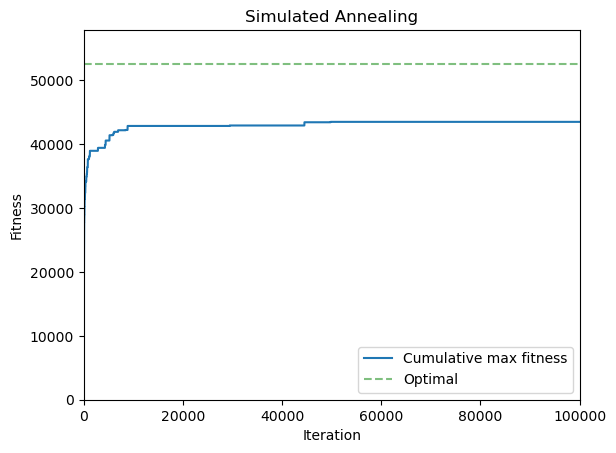

Experiment: Simulated Annealing
Best Fitness: 43515
 Knapsack 0: items [1, 19, 49, 64, 69, 75]
 Knapsack 1: items [14, 31, 57, 60, 65, 77, 81, 82, 93]
 Knapsack 2: items [2, 25, 33, 40, 43, 80, 85]
 Knapsack 3: items [3, 9, 20, 21, 23, 24, 27, 44, 74, 92]
 Knapsack 4: items [4, 12, 36, 42, 48, 53, 72, 87, 90, 97, 99]
 Knapsack 5: items [10, 18, 22, 39, 68, 78, 83, 84, 95]
 Knapsack 6: items [5, 8, 11, 13, 28, 52, 62]
 Knapsack 7: items [47, 50, 56, 59, 63]
 Knapsack 8: items [29, 30, 35, 45, 46, 76, 94]
 Knapsack 9: items [15, 16, 17, 37, 38, 58, 61, 89, 96]
 Unassigned items: [0, 6, 7, 26, 32, 34, 41, 51, 54, 55, 66, 67, 70, 71, 73, 79, 86, 88, 91, 98]



In [19]:
results = sa_solver(solution, max_iter=100000, restarted=True)
results.plot_fitness()
print(results)

100%|██████████| 9/9 [00:11<00:00,  1.30s/it]


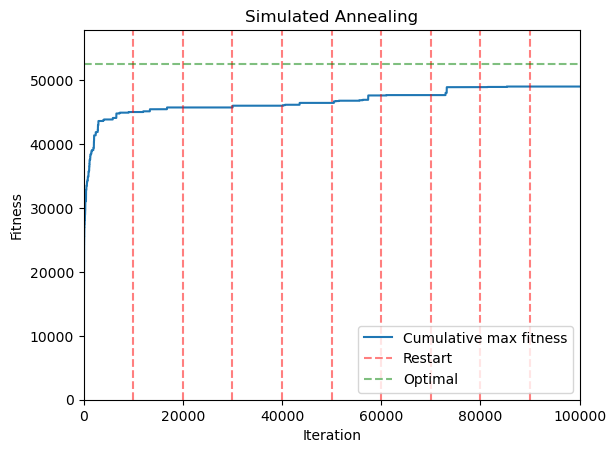

Experiment: Simulated Annealing
Best Fitness: 49046
 Knapsack 0: items [8, 13, 19, 35, 43, 62, 76]
 Knapsack 1: items [21, 25, 36, 63, 67, 86, 90]
 Knapsack 2: items [7, 29, 48, 61, 80, 85, 89]
 Knapsack 3: items [9, 12, 15, 24, 38, 42, 46, 54, 69, 72, 74, 84]
 Knapsack 4: items [5, 23, 30, 45, 58, 75, 79, 93, 97, 99]
 Knapsack 5: items [27, 34, 52, 60, 66, 68, 71, 91, 95]
 Knapsack 6: items [2, 11, 20, 22, 33, 39, 78, 87, 92]
 Knapsack 7: items [6, 26, 28, 37, 47, 88, 98]
 Knapsack 8: items [1, 4, 16, 59, 64, 83, 94, 96]
 Knapsack 9: items [14, 17, 18, 31, 49, 53, 56, 65, 70, 77, 81]
 Unassigned items: [0, 3, 10, 32, 40, 41, 44, 50, 51, 55, 57, 73, 82]



In [20]:
solution = np.ones(NUM_ITEMS, dtype=int) * -1
rounds = 10
schedule = np.ones(rounds) * 300
results = sa_solver(solution, max_iter=10000, initial_temp=schedule[0], restarted=True)
for i in tqdm(range(1, rounds)):
    new_results = sa_solver(results.best_solution, max_iter=10000, initial_temp=schedule[i], restarted=True)
    results.join(new_results)
results.plot_fitness()
print(results)

## Test problem 3

In [21]:
# Problem 3:
rng = np.random.default_rng(seed=42)
NUM_KNAPSACKS = 100
NUM_ITEMS = 5000
NUM_DIMENSIONS = 100
VALUES = rng.integers(0, 1000, size=NUM_ITEMS)
WEIGHTS = rng.integers(0, 1000, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = rng.integers(
    1000 * 10, 1000 * 2 * NUM_ITEMS // NUM_KNAPSACKS, size=(NUM_KNAPSACKS, NUM_DIMENSIONS)
)

In [22]:
solution = get_solution()

100%|██████████| 19/19 [05:27<00:00, 17.22s/it]


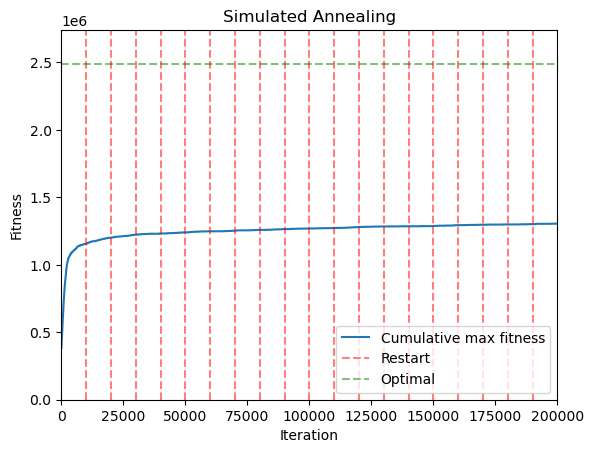

Experiment: Simulated Annealing
Best Fitness: 1304953
 Knapsack 0: items [18, 64, 242, 332, 333, 362, 761, 943, 952, 975, 1009, 1543, 1581, 1700, 1901, 2088, 2129, 2239, 2473, 2484, 2496, 3289, 3469, 3605, 3736, 3852, 4107, 4364, 4926]
 Knapsack 1: items [312, 405, 715, 849, 1136, 1311, 1576, 2060, 2120, 2270, 2299, 2479, 2656, 2872, 2980, 2984, 3037, 3039, 3048, 3511, 3599, 3696, 3738, 3755, 3773, 4215, 4335, 4397, 4444, 4913]
 Knapsack 2: items [44, 357, 492, 583, 728, 962, 1019, 1038, 1130, 1204, 1776, 1975, 2137, 2396, 2701, 3059, 3113, 3775, 3997, 4030, 4681, 4818, 4884]
 Knapsack 3: items [177, 214, 458, 930, 951, 1234, 1292, 1651, 2218, 2545, 2891, 3033, 3041, 3046, 3074, 3196, 3266, 3504, 3824, 3957, 4415, 4650, 4679]
 Knapsack 4: items [518, 610, 876, 1079, 1344, 1577, 1710, 2236, 2292, 2317, 2432, 2524, 2559, 2690, 2761, 2809, 2813, 3020, 3097, 3152, 3235, 3393, 3446, 3678, 4190, 4608, 4721, 4815, 4881, 4927]
 Knapsack 5: items [106, 140, 414, 517, 764, 949, 1217, 1305, 1313,

In [23]:
rounds = 20
temperature_schedule = np.ones(rounds) * 300
results = sa_solver(solution, max_iter=10000, initial_temp=temperature_schedule[0], restarted=False)
for i in tqdm(range(1, rounds)):
    new_results = sa_solver(results.best_solution, max_iter=10000, initial_temp=temperature_schedule[i], restarted=False)
    results.join(new_results)
results.plot_fitness()
print(results)